In [4]:
!pip install stable_baselines3==2.2.1
!apt-get update
!apt-get install -y python3-dev python3-pip python3-setuptools libswig-dev libpython3-dev libpython3-all-dev
!pip install gymnasium[atari]
!pip install gymnasium[accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.7/181.7 kB 4.8 MB/s eta 0:00:00
  Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 

CnnPolicy(
  (q_net): QNetwork(
    (features_extractor): NatureCNN(
      (cnn): Sequential(
        (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
        (1): ReLU()
        (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
        (3): ReLU()
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (5): ReLU()
        (6): Flatten(start_dim=1, end_dim=-1)
      )
      (linear): Sequential(
        (0): Linear(in_features=3136, out_features=512, bias=True)
        (1): ReLU()
      )
    )
    (q_net): Sequential(
      (0): Linear(in_features=512, out_features=6, bias=True)
    )
  )
  (q_net_target): QNetwork(
    (features_extractor): NatureCNN(
      (cnn): Sequential(
        (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
        (1): ReLU()
        (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
        (3): ReLU()
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (5): ReLU()
        (6): Flatten(start_dim=1, end_di

100%|██████████| 100000/100000 [03:44<00:00, 444.72it/s]


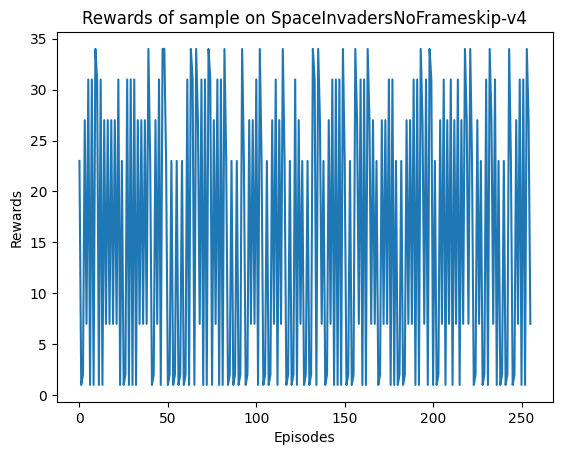

In [6]:
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.env_util import make_vec_env,make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
import os
env_id = "SpaceInvadersNoFrameskip-v4"
# get the current directory

# model_path = os.path.join(os.path.dirname(__file__), env_id+".zip")
# print(model_path)
import torch
from stable_baselines3.common.vec_env import VecTransposeImage, DummyVecEnv
from stable_baselines3.common.preprocessing import is_image_space
env = make_atari_env(env_id, n_envs=1)
env = VecTransposeImage(env)            # 确保图像通道在前

env=VecFrameStack(env, n_stack=4)

model = DQN("CnnPolicy", env, optimize_memory_usage=False, buffer_size=10)
model.policy.load_state_dict(torch.load("/content/policy.pth"))



print(model.policy)

import numpy as np
from tqdm import tqdm
obs = env.reset()
done = False
# sample 1M steps
n_steps = 100000
# num_episodes = 100

obs_list = []
next_obs_list = []
actions_list = []
rewards_list = []
dones_list = []
info_list = []
score_list=[]
reward_sum = 0
for i in tqdm(range(n_steps)):
    action, _states = model.predict(obs, deterministic=True)
    next_obs, reward, done, info = env.step(action)
    reward_sum += reward
    obs_list.append(obs)
    next_obs_list.append(next_obs)
    actions_list.append(action)
    rewards_list.append(reward)
    dones_list.append(done)
    info_list.append(info)
    obs = next_obs
    if done:
        obs = env.reset()
        score_list.append(reward_sum)
        reward_sum = 0

obs_list = np.array(obs_list)
actions_list = np.array(actions_list)
rewards_list = np.array(rewards_list)
dones_list = np.array(dones_list)
np.save(("obs.npy"), obs_list)
np.save(("actions.npy"), actions_list)
np.save(("rewards.npy"), rewards_list)
np.save(("dones.npy"), dones_list)
np.save(("info.npy"), info_list)
np.save(("next_obs.npy"), next_obs_list)

#　plot the score
import matplotlib.pyplot as plt
plt.plot(score_list)
plt.xlabel("Episodes")

plt.ylabel("Rewards")
plt.title("Rewards of sample on "+env_id)
plt.savefig("rewards.png")
plt.show()

# import agc.dataset as ds
# import agc.util as util

# # DATA_DIR is the directory, which contains the 'trajectories' and 'screens' folders
# dataset = ds.AtariDataset(DATA_DIR)


# # dataset.trajectories returns the dictionary with all the trajs from the dataset
# all_trajectories = dataset.trajectories

In [8]:
import gymnasium as gym
import numpy as np
from stable_baselines3.common.env_util import make_vec_env as make_vec_env_sb3
from copy import deepcopy
import torch
from torch.distributions import Normal
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import imageio
import pandas as pd
from tqdm import tqdm
from PIL import Image
from stable_baselines3.dqn.policies import MlpPolicy
import matplotlib.pyplot as plt


In [9]:
import gc
gc.collect()

3476

In [10]:
!nvidia-smi
# clean up memory forcefully
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device



Sun Apr 14 16:40:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   69C    P0              32W /  72W |    285MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

device(type='cuda')

In [11]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class CustomDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32,device=device)
        self.actions = torch.tensor(actions, dtype=torch.float32,device=device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

class PolicyNetwork(nn.Module):
    def __init__(self,  output_dim):
        super(PolicyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(3136, 512)
        self.fc2 = nn.Linear(512, output_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(x.size(0), -1)))
        x = self.fc2(x)
        return x



Using device: cuda


In [12]:
from stable_baselines3.common.env_util import make_atari_env
env_id="SpaceInvadersNoFrameskip-v4"
#env = make_vec_env_sb3(env_id, n_envs=1)
observations= np.load("/content/obs.npy", allow_pickle=True)
actions = np.load("/content/actions.npy", allow_pickle=True)
rewards = np.load("/content/rewards.npy", allow_pickle=True)
dones = np.load("/content/dones.npy", allow_pickle=True)
info = np.load("/content/info.npy", allow_pickle=True)
next_obs = np.load("/content/next_obs.npy", allow_pickle=True)
observations=observations.squeeze()
actions=actions.squeeze()
rewards=rewards.squeeze()
dones=dones.squeeze()
info=info.squeeze()
next_obs=next_obs.squeeze()
# observations = observations[:1000]
# actions = actions[:1000]
print(observations.shape, actions.shape, rewards.shape, dones.shape, info.shape, next_obs.shape)
# print(observations[0], actions[0], rewards[0], dones[0], info[0], next_obs[0])
print(info[0])
env = make_atari_env(env_id, n_envs=1)
from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage
env = VecTransposeImage(env)            # 确保图像通道在前
env = VecFrameStack(env, n_stack=4)     # 堆叠4帧
obs = env.reset()
print(obs.shape)

# print(env.action_space.n)
# print(env.observation_space.shape[0])

(100000, 4, 84, 84) (100000,) (100000,) (100000,) (100000,) (100000, 4, 84, 84)
{'lives': 3, 'episode_frame_number': 32, 'frame_number': 32, 'TimeLimit.truncated': False}
(1, 4, 84, 84)


In [13]:
class mydataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32)
        self.actions = torch.tensor(actions, dtype=torch.float32)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

In [21]:

policy_network = PolicyNetwork(env.action_space.n).to(device)
# nn init kaiming
torch.nn.init.kaiming_normal_(policy_network.conv1.weight)
torch.nn.init.kaiming_normal_(policy_network.conv2.weight)
torch.nn.init.kaiming_normal_(policy_network.conv3.weight)
torch.nn.init.kaiming_normal_(policy_network.fc1.weight)
torch.nn.init.kaiming_normal_(policy_network.fc2.weight)



train_dataset = CustomDataset(observations, actions)

optimizer = torch.optim.Adam(policy_network.parameters(), lr=1e-3,weight_decay=1e-4)


# Training loop
num_epochs = 30
batch_size = 32

train_dataloader = DataLoader(train_dataset , batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset , batch_size=batch_size, shuffle=True)
loss_func = nn.CrossEntropyLoss()
log_interval = len(observations)//10
num_test=5
test_score = 0
now_log=0
now_pos=0
graph=[]
eval_rewards=[]
for epoch in range(num_epochs):
    policy_network.train()

    # Compute the log probabilities of the actions
    pbar=tqdm(train_dataloader,position=0,leave=True)
    now_log=0
    now_pos=0
    for step, (obs_batch,act_batch) in enumerate(pbar):
        obs_batch=obs_batch.to(device)
        act_batch=act_batch.to(device)
        now_log+=obs_batch.shape[0]
        now_pos+=obs_batch.shape[0]

        logits = policy_network(obs_batch)
        # cross entropy
        loss=loss_func(logits, act_batch.long())

        # Optimize the policy
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()




        #scheduler

        graph.append(loss.detach().item())
        if now_log>=log_interval:
            now_log-=log_interval

            policy_network.eval()  # 切换到评估模式



            total_reward=0
            # test the policy and save as the first test as gif
            frames = []
            saved_frame = False
            for _ in range(num_test):
                state = env.reset()
                done = False
                while not done:
                    state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
                    with torch.no_grad():
                        action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()

                    state, reward, done, _ = env.step(action)  # 执行动作
                    total_reward += reward
                    if not saved_frame:
                        frame = env.render(mode="rgb_array")
                        frames.append(frame)  # 添加到帧列表中
                # 保存为GIF
                if not saved_frame:
                    saved_frame = True
                    image_path = f"epoch_{epoch+1}_iteration_{now_pos}.gif"
                    imageio.mimsave("./gif/"+image_path, frames)



            # print(total_reward/num_test)
            test_score = total_reward/num_test

            eval_rewards.append(total_reward/num_test)

            policy_network.train()
        pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
        pbar.set_postfix({"loss":loss.detach().item(), "test_score":test_score})
env.close()




Epoch [30/30]: 100%|██████████| 3125/3125 [01:04<00:00, 48.08it/s, loss=0.471, test_score=[4.8]] 


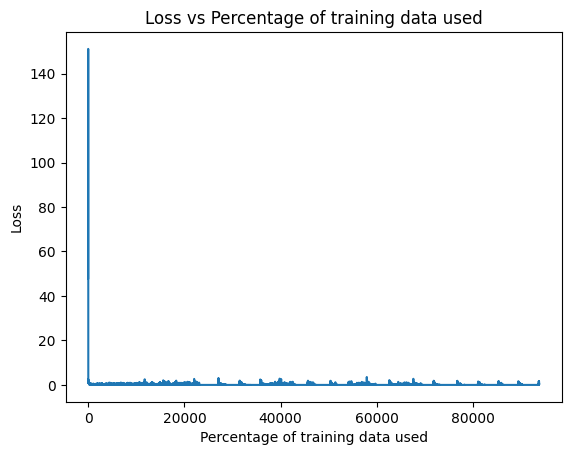

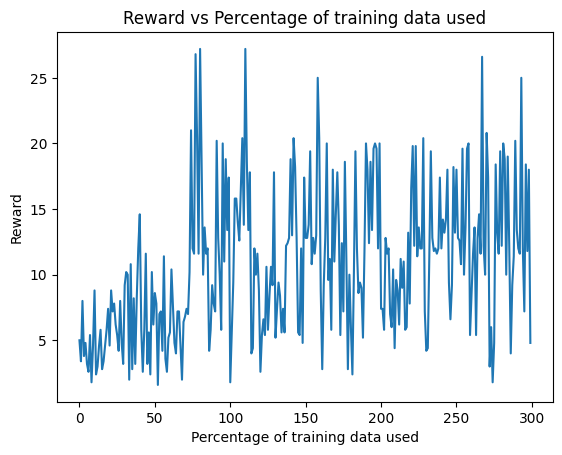

In [25]:
# draw the loss graph
import matplotlib.pyplot as plt
plt.plot(graph)
plt.xlabel("Percentage of training data used")
plt.ylabel("Loss")
plt.title("Loss vs Percentage of training data used")

plt.savefig("./loss.png")
plt.show()
# draw the reward graph
plt.plot(eval_rewards)
plt.xlabel("Percentage of training data used")
plt.ylabel("Reward")
plt.title("Reward vs Percentage of training data used")
plt.savefig("./reward.png")
plt.show()




In [26]:
!zip -r g /content/gif

updating: content/gif/ (stored 0%)
updating: content/gif/highest_epoch_1_iteration_20000.gif (deflated 32%)
updating: content/gif/sample_epoch_14_iteration_1310016.gif (deflated 29%)
updating: content/gif/sample_epoch_8_iteration_800000.gif (deflated 30%)
updating: content/gif/sample_epoch_19_iteration_1870016.gif (deflated 31%)
updating: content/gif/sample_epoch_25_iteration_2490016.gif (deflated 31%)
updating: content/gif/highest_epoch_10_iteration_1000000.gif (deflated 32%)
updating: content/gif/sample_epoch_6_iteration_560000.gif (deflated 33%)
updating: content/gif/highest_epoch_4_iteration_350016.gif (deflated 28%)
updating: content/gif/highest_epoch_3_iteration_270016.gif (deflated 27%)
updating: content/gif/highest_epoch_19_iteration_1850016.gif (deflated 30%)
updating: content/gif/sample_epoch_1_iteration_80000.gif (deflated 27%)
updating: content/gif/sample_epoch_23_iteration_2250016.gif (deflated 28%)
updating: content/gif/sample_epoch_16_iteration_1560000.gif (deflated 28%)